### imports

In [1]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(f'BASE_DIR: {BASE_DIR}')

from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras


BASE_DIR: /Users/bbhandar/UAH/GRA_Work/aq_downscale_github


### useful functions

In [2]:
def make_dataset(data, targets, window_size, shuffle=False):
    data = np.array(data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=1,
    )

    return ds

### variables

In [8]:
window_size = 5

In [23]:
start_date = '1990-01-01'
end_date = '2019-12-31'
full_dates = pd.date_range(datetime.strptime(start_date, '%Y-%m-%d'),
                           datetime.strptime(end_date, '%Y-%m-%d'), freq='d')\
             .strftime('%Y-%m-%d').tolist()
idx = pd.DatetimeIndex(pd.date_range(start=start_date, end=end_date, freq='1D'))
len(full_dates)

10957

In [24]:
model_folder = f'{BASE_DIR}/models/rf'
output_folder = f'{BASE_DIR}/output/rf'

Path(f'{model_folder}').mkdir(parents=True, exist_ok=True)
Path(f'{output_folder}').mkdir(parents=True, exist_ok=True)

#### train

In [21]:
n_estimators = 80

In [26]:
# load the dataset
df = pd.read_csv(f'{BASE_DIR}/example_training/example.csv', header=0, index_col='datetime')
df = df.loc[(df.observation > 0) & (df.prediction > 0)]
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# reindex df to contain all the dates
df = df.reindex(idx, fill_value=np.nan)

targets = df.observation.values.tolist()
_df = df.drop(['observation'], axis=1)
data = _df.values.tolist()

# make time-series data for that station
inputs = []
labels = []
dataset = make_dataset(data, targets[window_size:], window_size)
for sample, target in dataset:
    inputs.append(sample.numpy().flatten())
    labels.append(target.numpy().flatten())

# all data
inputs = np.vstack(np.array(inputs))
labels = np.vstack(np.array(labels))

# removing nans
# first for inputs
data_isnan = np.isnan(inputs).any(axis=1)
inputs = inputs[~data_isnan]
labels = labels[~data_isnan]

# next for labels
label_isnan = np.isnan(labels).any(axis=1)
inputs = inputs[~label_isnan]
labels = labels[~label_isnan]
labels = labels.ravel()

input_train, input_test, label_train, label_test = train_test_split(inputs, labels, train_size=0.7, random_state=42)

model = RandomForestRegressor(n_estimators=n_estimators, criterion='squared_error', oob_score=True, n_jobs=4)
# fit model
model.fit(input_train, label_train)

# make predictions
test_predictions = model.predict(input_test)

test_mae = np.mean(np.absolute(label_test - test_predictions))

print(f'test mae: {test_mae}')

print(f'oob_score: {model.oob_score_}')

test_dict = {'prediction': test_predictions, 'label': label_test} 
test_pred_df = pd.DataFrame(test_dict) 
test_pred_df.to_csv(f'{output_folder}/model_output.csv', index=False)



test mae: 17.687132444530725
oob_score: 0.7238762962494437


#### plot

test mae: 21.774604361044954


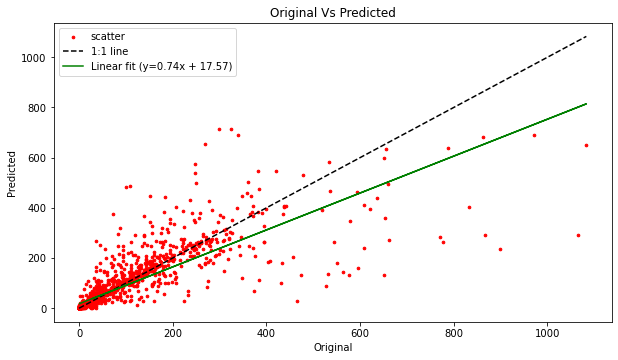

In [8]:
test_df = pd.read_csv(f'{output_folder}/model_output.csv', header=0)

original = test_df.label
predicted = test_df.prediction

test_mae = mean_absolute_error(original, predicted)

print(f'test mae: {test_mae}')

x_ex = np.linspace(0, original.max(), num=10000)
coefficients, others = np.polynomial.polynomial.polyfit(original, predicted, 1, full=True)
# the order are reversed with polynomial.polyfit
coefficients = coefficients[::-1]
m, c = coefficients[0], coefficients[1]
pred = [m*i + c for i in original]
pred_eqn = f'y={round(m, 2)}x + {round(c, 2)}' if c >0 else f'y={round(m, 2)}x {round(c, 2)}'

fig, axs = plt.subplots(figsize=(10, 5.5))

axs.scatter(original, predicted, marker='o', c='red', s=7, label='scatter')
axs.plot(x_ex, x_ex, '--k', label='1:1 line')
axs.plot(original, pred, '-g', label=f'Linear fit ({pred_eqn})')
axs.set_title(f'Original Vs Predicted')
axs.set_xlabel('Original')
axs.set_ylabel('Predicted')
axs.legend(loc='upper left')

plt.show()
